# Предсказание популярности постов на Главной Aftershock.news

In [2]:
# Загрузка библиотек

# Библиотеки для парсинга
import requests # Создание запросов к сайту 
from bs4 import BeautifulSoup # Обработка запросов
import re # Обработка регулярных выражений

# Библиотеки для работы с данными
import pandas as pd # Работа с данным в формате DataFrame
import numpy as np # Работа с массивами

# Случайный лес (для классификации текстов по формальным признакам)
from sklearn.ensemble import RandomForestClassifier

# Библитотеки для машинного обучения
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer # Векторизация и трансформация 
from sklearn.linear_model import LogisticRegression, SGDClassifier # Логистическая регрессия и SGD-классификация
from sklearn.svm import LinearSVC # SVC-классификация
from sklearn.model_selection import train_test_split, cross_val_score # Разделение выборки на тестовую и тренировочную
from sklearn import cross_validation, grid_search, metrics # Кросс-валидация, поиск по сетке и метрики качества
from sklearn.pipeline import Pipeline # Организация конвейерной подачи данных

# Библиотеки для визуализации
import matplotlib.pyplot as plt # Для построения графиков
import seaborn as sns # Для более наглядного построения графиков
from matplotlib.colors import LinearSegmentedColormap # Создание собственной цветовой карты
plt.style.use('seaborn-poster') # Настройка стиля визуализации

# Библиотеки для анализа текста
import wordcloud # Визуализация текста в виде облака тегов
import pymorphy2 # Морфологический анализ
from gensim import corpora, models # Тематическое моделирование

# Библиотека для сохранения и загрузки моделей на диск
import pickle

# Библиотека для работы с предупреждениями
import warnings
warnings.filterwarnings('ignore') # Игнорировать предупреждения

## Парсинг

In [52]:
# Генерация ссылок на страницы
url = []
for i in range(1823):
    url.append('https://aftershock.news/?q=front&page='+str(i))

# Сбор ссылок на публикации
links = []
for j in url:
    page = requests.get(j).text
    page = BeautifulSoup(page, 'lxml')
    for i in page.find_all('span', class_='aft-postheadericon'):
        try:
            links.append(re.search('/\?q=node/\d+', str(i)).group(0))
        except:
            print(j)
            
# Сохранение ссылок на диск
with open('../data/links_2018_02_15.pkl', 'wb') as f:
    pickle.dump(links, f)

In [24]:
# Загрузка ссылок
with open('../data/links_2018_02_15.pkl', 'rb') as f:
    links = pickle.load(f)

In [4]:
# Парсер
n = 0
for i in links[25001:]:
    i = 'https://aftershock.news'+i
    page = requests.get(i)
    page.encoding = 'utf-8'
    page = BeautifulSoup(page.text, 'lxml')
    try:
        heads = page.find('span', class_='aft-postheadericon').get_text()
    except:
        print(i, n)
        continue
    length_heads = len(heads)
    date = page.find('span', class_='aft-postdateicon').get_text()
    counts = re.search('\d+', str(page.find('span', class_='aft-postcounter'))).group(0)
    writers = page.find('span', class_='aft-postauthoricon').get_text()
    age = page.find('span', class_='aft-commentauthorage').get_text()
    tags = re.findall('#\w+ ?\w+', str(page.find_all('span', class_='publication-tags-item')))
    categories = re.findall('@\w+ ?\w+', str(page.find_all('span', class_='publication-tags-category-item')))
    try:
        authorship = page.find('div', 
                           class_='field field-name-field-authorship field-type-list-boolean field-label-inline clearfix').get_text()
    except:
        authorship = 'неизвестно'
    try:
        sources = page.find('div', class_='field field-name-field-sources field-type-link-field field-label-inline clearfix').get_text()
    except:
        sources = 'неизвестно'
    try:
        texts = page.find('div', class_='field field-name-body field-type-text-with-summary field-label-hidden').get_text()
    except:
        texts = 'нет'
    lenght_texts = len(texts)
    urls = i
    # Создание датафрейма
    df = pd.DataFrame({'heads': [heads], 
                       'length_heads': [length_heads], 
                       'date': [date], 
                       'counts': [counts],
                       'writers': [writers],
                       'age': [age],
                       'tags': [tags],
                       'categories': [categories],
                       'authorship': [authorship],
                       'sources': [sources],
                       'texts': [texts],
                       'lenght_texts': [lenght_texts],
                       'urls': [urls]})
    # Запись в файл
    df.to_csv('../data/20180215_aftershock_raw.csv', index=False, encoding='utf-8', mode='a', header=False)
    n += 1
    print(n, end='')
    print('\r', end='')

Wall time: 9h 48min 20s


## Характеристики публикаций

### Очистка данных

In [2]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock_raw_new.csv')

In [129]:
# Замена NA
df.texts[df.texts.isnull()] = 'нет'
df.lenght_texts[df.texts == 'нет'] = 0

# Приведение времени на сайте к числовому формату
df.age = df.age.str.replace('\(', '')
df.age = df.age.str.replace('\)', '')
df.age = df.age.str.replace('^| лет .*', '')
df.age = df.age.str.replace('^| год.*', '')
df.age = df.age.str.replace('^\d+ мес.*', '0')
df.age = df.age.str.replace('^\d+ недел.*', '0')
df.age = df.age.str.replace('48', '0')
df.age = df.age.astype('int')

# Очистка колнки "Авторство"
df.authorship = df.authorship.str.replace('Авторство:\xa0', '')

# Очистка тегов и категорий от лишних символов
df.categories = df.categories.str.replace('[\[\'@\]]', '')
df.categories[df.categories == ""] = 'нет'
df.tags = df.tags.str.replace('[\[\'#\]]', '')
df.tags[df.tags == ""] = 'нет'
df.categories = df.categories.str.replace('Публицистика и', 'Публицистика и обсуждения')
df.categories = df.categories.str.replace('Социология и', 'Социология и демография')
df.categories = df.categories.str.replace('Страны', 'Страны / география')
df.categories = df.categories.str.replace('Это америка', 'Это америка бро')
df.categories = df.categories.str.replace('Люди и', 'Люди и персоналии')
df.tags = df.tags.str.replace('Люди и', 'Люди и персоналии')
df.tags = df.tags.str.replace('Новый Мировой', 'Новый Мировой Порядок')
df.tags = df.tags.str.replace('Инфовойна в', 'Инфовойна в масс-медиа')
df.tags = df.tags.str.replace('Сводка с', 'Сводка с фронтов')
df.tags = df.tags.str.replace('Как это', 'Как это было')
df.tags = df.tags.str.replace('Хороший', 'Хороший годный чат')
df.tags = df.tags.str.replace('Новая темная', 'Новая темная эра уже рядом')

# Создание колонок с днём недели, годом, месяцем, днём месяца и часом
df['day_week'] = df.date.str.extract('(^\w+)')
df['hours'] = df.date.str.replace('.*- |:..$', '')
df.date = df.date.str.replace('^\w+, | - .*$', '')
df['day_month'] = df.date.str.extract('(^\w+)')
df['month'] = df.date.str.replace('^\d+/|/\d+', '')
df['year'] = df.date.str.extract('(\w+$)')
df.hours = df.hours.astype('int')
df.day_month = df.day_month.astype('int')
df.month = df.month.astype('int')
df.year = df.year.astype('int')

# Тип данных колонки "Длина текста" в int
df.lenght_texts = df.lenght_texts.astype('int')

# Предварительная очистка колонки "Источники"
df.sources = df.sources.str.replace('Использованные источники:\xa0', '')
df.sources[df.sources.str.contains('РИА')] = 'РИА Новости'

In [130]:
# Сохранение данных
df.to_csv('../data/20180215_aftershock.csv', encoding='utf-8', index=False)

### Подготовка данных

In [3]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')

In [6]:
df.head()

,age,authorship,categories,counts,date,heads,lenght_texts,length_heads,sources,tags,texts,urls,writers,day_week,hours,day_month,month,year
0,4,Копия чужих материалов,"Обезьяны атакуют, Страны / география, Хроники,...",16665,15/02/2018,"СНБО Украины: Россия сочла нас ""лохами"" и разд...",1193,99,Вести,"Ржака, Россия, Украина, Заявления, Армия, Перс...","Россия должна вернуть Украине корабли, останов...",https://aftershock.news/?q=node/617278,Влад-Днепр,чт,17,15,2,2018
1,3,Копия чужих материалов,"Обезьяны атакуют, Страны / география, Хроники,...",18611,15/02/2018,Премьер Польши: «Северный поток — 2» может при...,1169,84,Премьер Польши: «Северный поток — 2» может при...,"Шайтаны, Ржака, Европа, Россия, Украина, Заявл...",\r\r\r\nПремьер-министр Польши Матеуш Моравецк...,https://aftershock.news/?q=node/617238,Замполит,чт,16,15,2,2018
2,3,Копия чужих материалов,"Военное, Страны / география, Хроники, Холодная...",10889,15/02/2018,МИД назвал дезинформацией сообщения о гибели в...,4411,63,ИзвестияМИД РФ,"Ближний Восток, Россия, США, Заявления, Инфово...",Официальный представитель Министерства иностра...,https://aftershock.news/?q=node/617236,Comm,чт,16,15,2,2018
3,2,Авторская работа / переводика,"Публицистика и обсуждения, Страны / география,...",3692,15/02/2018,О Родине и государстве. Патриотизм.,5838,35,неизвестно,"Мораль, Национальная идея, Мнение, Россия, Воп...","Так случилось, что попались и на глаза и в гол...",https://aftershock.news/?q=node/613284,Emp_IL,чт,15,15,2,2018
4,4,Копия чужих материалов,"Военное, Обезьяны атакуют, Социальная инфрастр...",5501,15/02/2018,Генпрокуратура: При утилизации химоружия расхи...,906,64,В Генпрокуратуре заявили о хищениях при утилиз...,"ВПК, Военный попил, Шайтаны, Правопорядок, Рос...",Генпрокурор России Юрий Чайка в ходе расширенн...,https://aftershock.news/?q=node/617208,ПиротехникЪ,чт,14,15,2,2018


In [287]:
# Разделение на классы
df['Classes'] = 'Обычный пост'
df['Classes'][df.iloc[:,3] < df.describe().iloc[4, 1]] = 'Непопулярный пост'
df['Classes'][df.iloc[:,3] > df.describe().iloc[6, 1]] = 'Популярный пост'

# Удаление "обычного поста"
df = df[df.Classes != 'Обычный пост']

In [288]:
# Размеры классов
df.Classes.value_counts()

Популярный пост      9102
Непопулярный пост    9096
Name: Classes, dtype: int64

In [289]:
# Удаление лишних колонок
df = df.drop(['date', 'counts', 'heads', 'texts', 'urls'], 1)

# Перевод в факторы и кодировка
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

In [292]:
# Разделение на тренировочный и тестовый датасет
labels = df.pop('Classes').values
train, test, train_labels, test_labels = train_test_split(df, labels, test_size = 0.3)

### Случайный лес

In [295]:
# Создание модели
model = RandomForestClassifier()

# Создание сетки с параметрами
parameters_grid = {
    'max_depth' : [5, 20, 40, 150],
    'n_estimators' : [150, 300, 500, 1000],
}

# Стратегия кроссвалидации
cv = cross_validation.StratifiedShuffleSplit(train_labels, n_iter = 3, test_size = 0.3)

# Стратегия поиска по сетке
grid_cv = grid_search.GridSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Тренировка модели
grid_cv.fit(train, train_labels)

# Характеристики лучшей модели
grid_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [296]:
# Предсказание и метрики
predict_labels = grid_cv.predict(test)
print(metrics.classification_report(test_labels, predict_labels))

             precision    recall  f1-score   support

          0       0.87      0.79      0.83      2814
          1       0.80      0.87      0.83      2646

avg / total       0.83      0.83      0.83      5460



### Информативность признаков

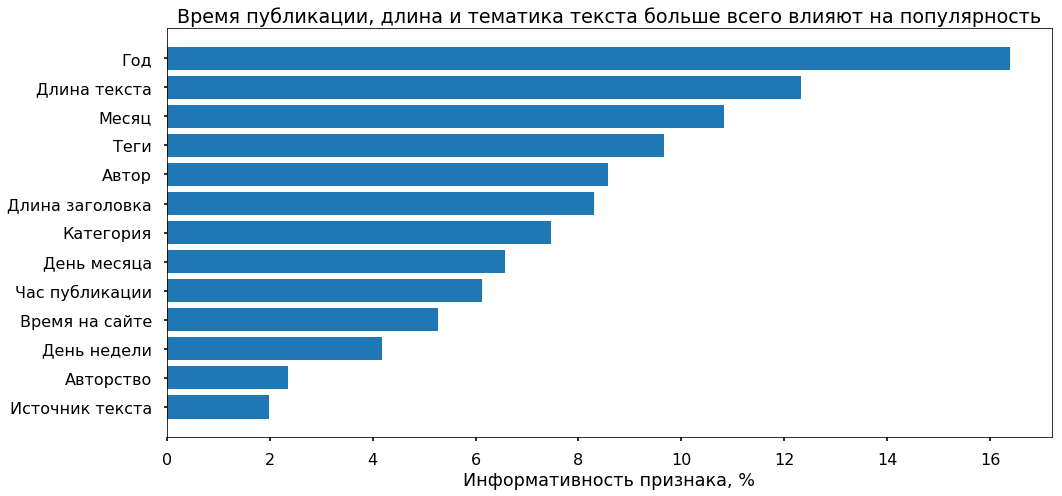

In [308]:
# Информативность признаков
df_plot = pd.DataFrame({'features': train.columns.tolist(),
                       'importances': grid_cv.best_estimator_.feature_importances_})
df_plot['importances'] = df_plot['importances']*100
df_plot['importances'] = round(df_plot['importances'], 2)
df_plot['features'] = df_plot['features'].astype('category')
df_plot['features'].cat.categories = ["Время на сайте", "Авторство", "Категория", "День месяца", "День недели", "Час публикации",
                                      "Длина текста", "Длина заголовка", "Месяц", "Источник текста", "Теги", "Автор", "Год"]
df_plot = df_plot.sort_values(['importances'], ascending = False)
df_plot['features'] = df_plot['features'].astype('str')

# График "Информативность признаков"
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_plot.features))[::-1], df_plot.importances)
ax.set_yticks(np.arange(len(df_plot.features))[::-1])
ax.set_yticklabels(df_plot.features)
plt.title('Время публикации, длина и тематика текста больше всего влияют на популярность')
plt.ylabel('')
plt.xlabel('Информативность признака, %')
plt.tight_layout()
plt.show()
fig.savefig('../images/Важность признаков.png')

### Динамика количества просмотров и комментариев

In [360]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [366]:
# Подсчёт количества комментариев и просмотров
df_posts = df[['date', 'counts']]
df_posts['posts'] = 1
df_posts = df_posts.groupby(['date'])
df_posts = df_posts[['counts', 'posts']].sum()
df_posts = df_posts.resample('M').sum()

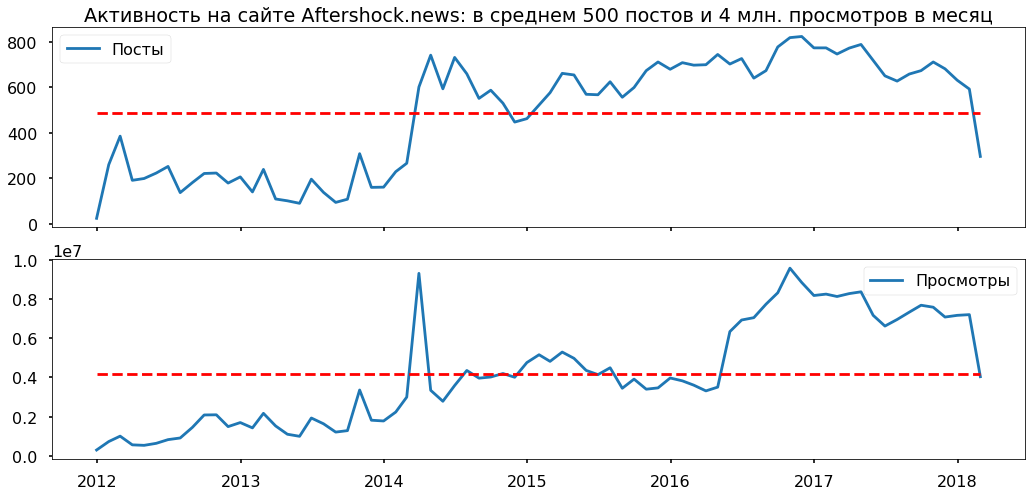

In [397]:
# Plot
fig = plt.figure(figsize=[15, 7])

plt.subplot(211)
plt.plot(df_posts.posts, '-', label='Посты')
plt.plot(df_posts.index, [df_posts.posts.mean()]*len(df_posts), color='r', ls='--')
plt.tick_params(labelbottom='off')
plt.title('Активность на сайте Aftershock.news: в среднем 500 постов и 4 млн. просмотров в месяц')
plt.legend()

plt.subplot(212)
plt.plot(df_posts.counts, '-', label='Просмотры')
plt.plot(df_posts.index, [df_posts.counts.mean()]*len(df_posts), color='r', ls='--')
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('../images/Динамика количества просмотров и комментариев.png')

### Длина текста

In [6]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [9]:
# Добавление квантилей
df_len_text = df[['lenght_texts', 'counts']]
df_len_text['quant'] = 'Q'
df_len_text.quant[df_len_text['lenght_texts'] < 2094] = 'меньше 2094 символов'
df_len_text.quant[df_len_text['lenght_texts'] >= 2094] = 'больше 2094 символов'
df_len_text.quant = df_len_text.quant.astype('category')

In [15]:
# Статистика по квантилям
print(df_len_text.counts[df_len_text.quant == 'меньше 2094 символов'].describe(),  
      df_len_text.counts[df_len_text.quant == 'больше 2094 символов'].describe())

count     18202.000000
mean       7625.705637
std        6207.821955
min         129.000000
25%        3897.000000
50%        5990.000000
75%        9361.500000
max      176766.000000
Name: counts, dtype: float64   count     18207.000000
mean       9663.517548
std        8143.731765
min         152.000000
25%        4919.000000
50%        7605.000000
75%       11892.000000
max      237503.000000
Name: counts, dtype: float64


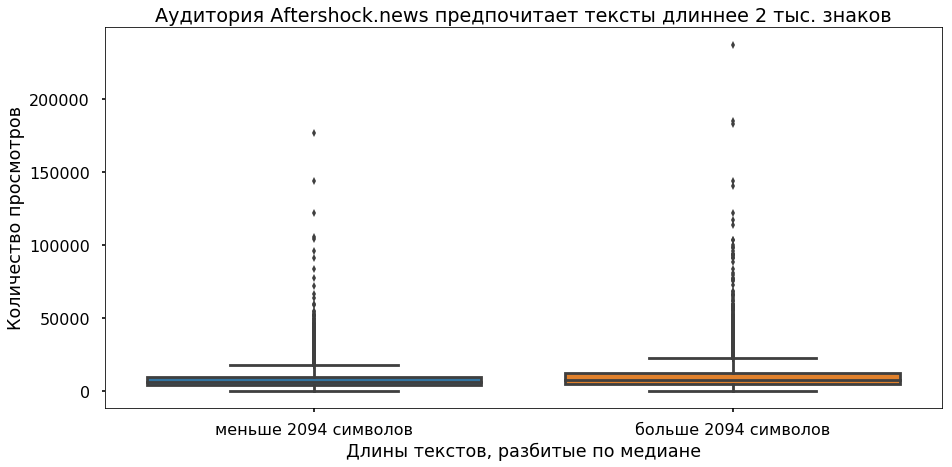

In [34]:
# Plot
fig = plt.figure(figsize=[15, 7])
sns.boxplot(x='quant', y='counts', order=['меньше 2094 символов', 
                                         'больше 2094 символов'], data=df_len_text)
plt.title('Аудитория Aftershock.news предпочитает тексты длиннее 2 тыс. знаков')
plt.ylabel('Количество просмотров')
plt.xlabel('Длины текстов, разбитые по медиане')
plt.show()
fig.savefig('../images/Аудитория Aftershock.news предпочитает длинные тексты.png')

### Месяц

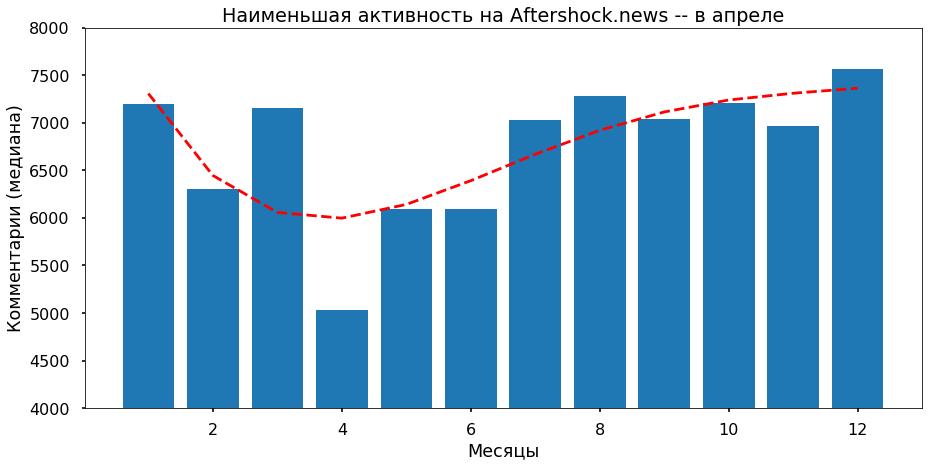

In [23]:
# Сабсет со временем суток
df_month = df[['date', 'counts']]
df_month.date = pd.to_datetime(df_month.date)
df_month['month'] = df_month.date.dt.month
df_month.index = df_month.pop('date')
df_month = df_month.groupby(['month'])
df_month = df_month.counts.median().reset_index()

# Plot
fig = plt.figure(figsize=(15, 7))
plt.bar(df_month.month.tolist(), df_month.counts.tolist())
z = np.polyfit(df_month.month.tolist(), df_month.counts.tolist(), 4)
p = np.poly1d(z)
plt.plot(df_month.month.tolist(), p(df_month.month.tolist()),"r--")
plt.ylim(4000, 8000)
plt.title("Наименьшая активность на Aftershock.news -- в апреле")
plt.xlabel('Месяцы')
plt.ylabel('Комментарии (медиана)')
plt.show()
fig.savefig('../images/Месяц публикации.png')

### Теги

In [102]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [33]:
# Подсчёт медианы по группам тегов с частотой больше 5
df_tags = df[['counts', 'tags']]
df_tags = df_tags[df_tags.tags.isin(df.tags.value_counts()[df.tags.value_counts() >= 5].index)]
df_tags = df_tags.groupby('tags')['counts'].median().reset_index()
df_tags = df_tags.sort_values('counts', ascending=False)
df_tags = df_tags.head(10)

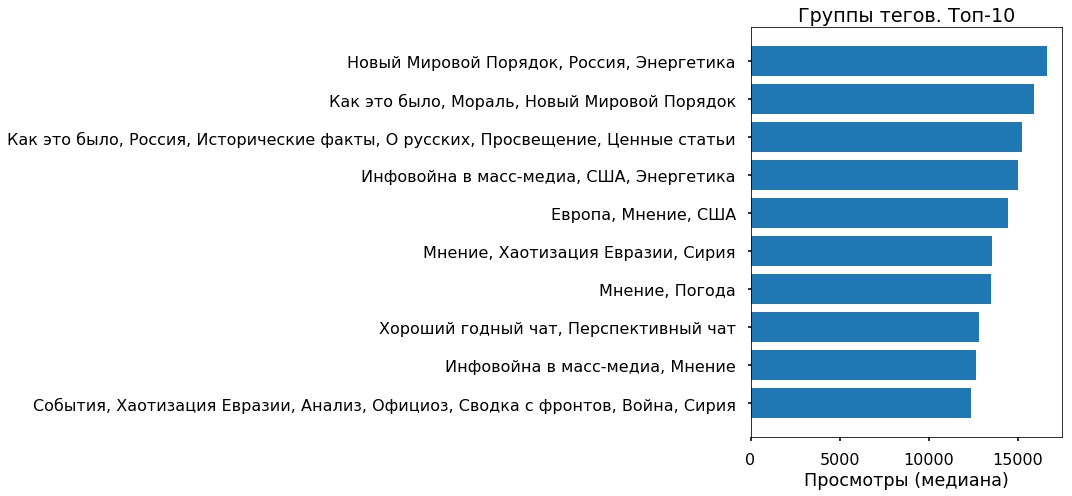

In [34]:
# График
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_tags.tags))[::-1], df_tags.counts)
ax.set_yticks(np.arange(len(df_tags.tags))[::-1])
ax.set_yticklabels(df_tags.tags)
plt.title('Группы тегов. Топ-10')
plt.ylabel('')
plt.xlabel('Просмотры (медиана)')
plt.tight_layout()
plt.show()
fig.savefig('../images/Группы тегов топ.png')

### Топ-10 авторов

In [2]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [3]:
# Сабсет с авторами
df_writers = df[['writers','counts']]

# более 5 постов -- у 30% авторов, эти авторы написали 90% всех материалов, 
# среднее кол-во просмотров поста -- 8645, медиана -- 6734
index = df_writers.writers.value_counts()[df_writers.writers.value_counts() >= 5].index.tolist()
df_writers = df_writers.loc[df_writers['writers'].isin(index)]
df_writers = df_writers.groupby(['writers'])
df_writers = df_writers[['counts']].median().sort_values(['counts'], ascending = False).reset_index()
df_writers = df_writers.head(10)

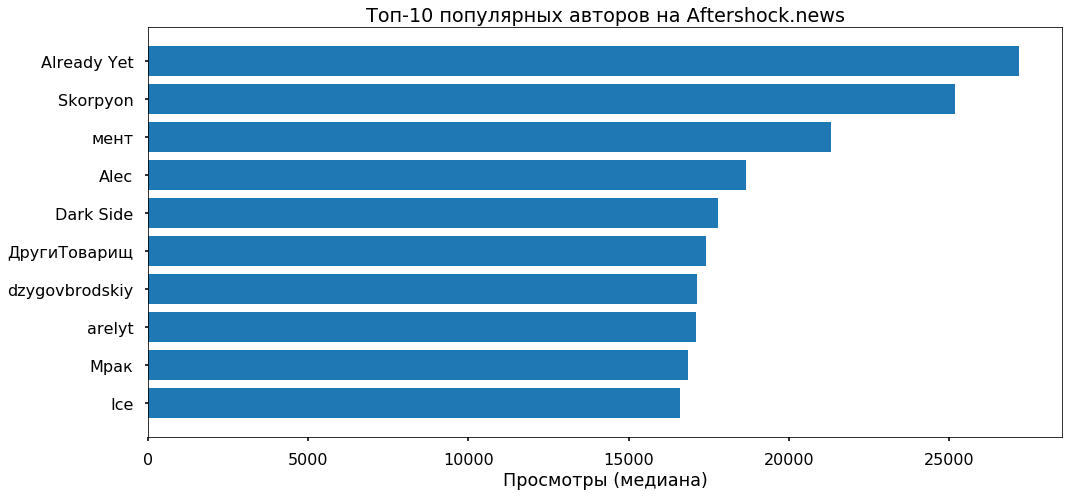

In [36]:
# График
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_writers.writers))[::-1], df_writers.counts)
ax.set_yticks(np.arange(len(df_writers.writers))[::-1])
ax.set_yticklabels(df_writers.writers)
plt.title('Топ-10 популярных авторов на Aftershock.news')
plt.ylabel('')
plt.xlabel('Просмотры (медиана)')
plt.tight_layout()
plt.show()
fig.savefig('../images/Популярные авторы.png')

### Категории

In [131]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [40]:
# Удаление категорий Лидеры просмотров и Лидеры обсуждений
df_cat = df[['counts', 'categories']]
df_cat = df_cat[df_cat.categories != "Лидеры просмотров"]
df_cat.categories = df_cat.categories.str.replace(', Лидеры обсуждений', '')
df_cat.categories = df_cat.categories.str.replace(', Лидеры просмотров', '')
# Подсчёт медианы по группам тегов с частотой больше 5
df_cat = df_cat[df_cat.categories.isin(df.categories.value_counts()[df.categories.value_counts() >= 5].index)]
df_cat = df_cat.groupby('categories')['counts'].median().reset_index()
df_cat = df_cat.sort_values('counts', ascending=False)
df_cat = df_cat.head(10)

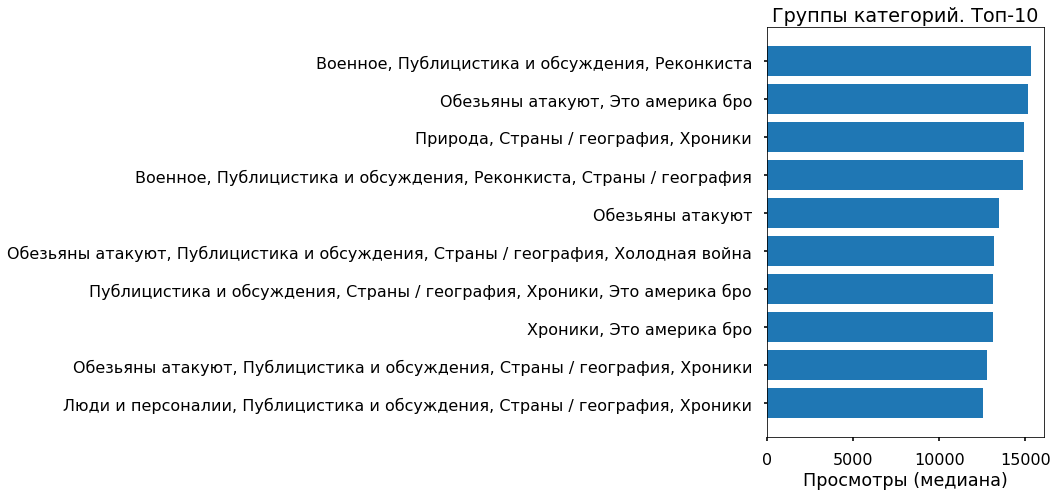

In [41]:
# График
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_cat.categories))[::-1], df_cat.counts)
ax.set_yticks(np.arange(len(df_cat.categories))[::-1])
ax.set_yticklabels(df_cat.categories)
plt.title('Группы категорий. Топ-10')
plt.ylabel('')
plt.xlabel('Просмотры (медиана)')
plt.tight_layout()
plt.show()
fig.savefig('../images/Группы категорий топ.png')

### Длина заголовков

In [4]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

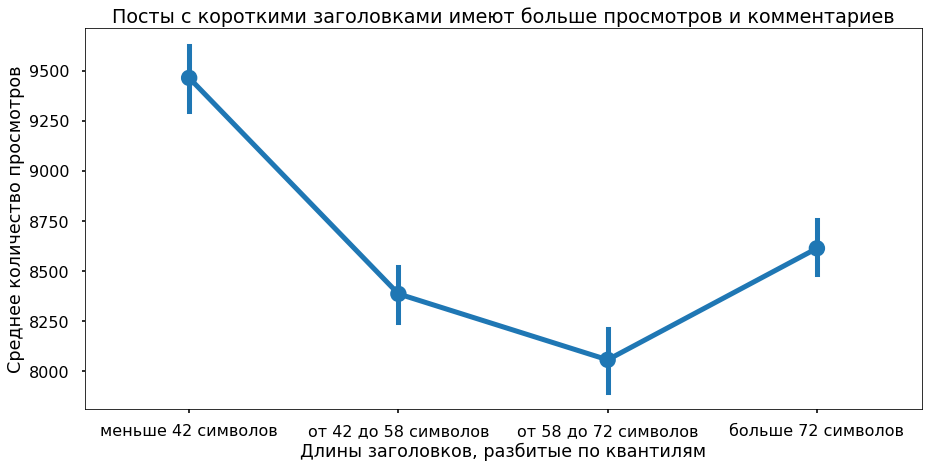

In [8]:
# Добавление квантилей
df_len = df[['length_heads', 'counts']]
df_len['quant'] = 'Q'
df_len.loc[df_len['length_heads'] <= df_len.length_heads.describe()[4], 'quant'] = 'меньше 42 символов'
df_len.loc[(df_len['length_heads'] > df_len.length_heads.describe()[4]) & 
           (df_len['length_heads'] <= df_len.length_heads.describe()[5]), 'quant'] = 'от 42 до 58 символов'
df_len.loc[(df_len['length_heads'] > df_len.length_heads.describe()[5]) & 
           (df_len['length_heads'] < df_len.length_heads.describe()[6]), 'quant'] = 'от 58 до 72 символов'
df_len.loc[df_len['length_heads'] >= df_len.length_heads.describe()[6], 'quant'] = 'больше 72 символов'
df_len_describe = df_len.length_heads.describe() # Описательная статистика колонки length
df_len.quant = df_len.quant.astype('category')

# Plot
fig = plt.figure(figsize=[15, 7])
sns.pointplot(x='quant', y='counts', order=['меньше 42 символов', 
                                         'от 42 до 58 символов', 
                                         'от 58 до 72 символов',
                                         'больше 72 символов'], data=df_len)
plt.title('Посты с короткими заголовками имеют больше просмотров и комментариев')
plt.ylabel('Среднее количество просмотров')
plt.xlabel('Длины заголовков, разбитые по квантилям')
plt.show()
fig.savefig('../images/Длина заголовков.png')

### День месяца

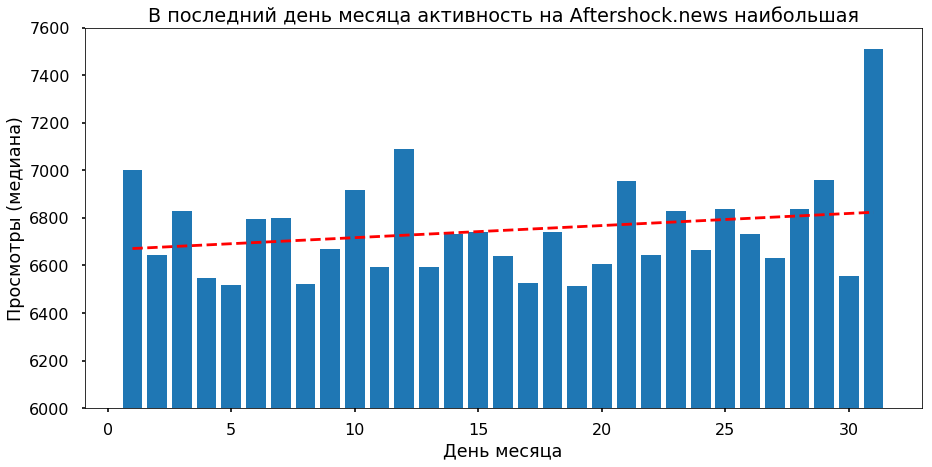

In [55]:
# Данные по дням месяца
df_days = df[['date', 'counts']]
df_days.date = df_days.date.astype('str')
df_days['days'] = df_days.date.str.extract('(..$)')
df_days.index = df_days.pop('date')
df_days = df_days.groupby(['days'])
df_days = df_days.counts.median().reset_index()
df_days.days = df_days.days.astype('int')

# Plot
fig = plt.figure(figsize=(15, 7))
plt.bar(df_days.days.tolist(), df_days.counts.tolist())
z = np.polyfit(df_days.days.tolist(), df_days.counts.tolist(), 1)
p = np.poly1d(z)
plt.plot(df_days.days.tolist(), p(df_days.days.tolist()),"r--")
plt.ylim(6000, 7600)
plt.title("В последний день месяца активность на Aftershock.news наибольшая")
plt.xlabel('День месяца')
plt.ylabel('Просмотры (медиана)')
plt.show()
fig.savefig('../images/День месяца.png')

### Час публикации

In [14]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

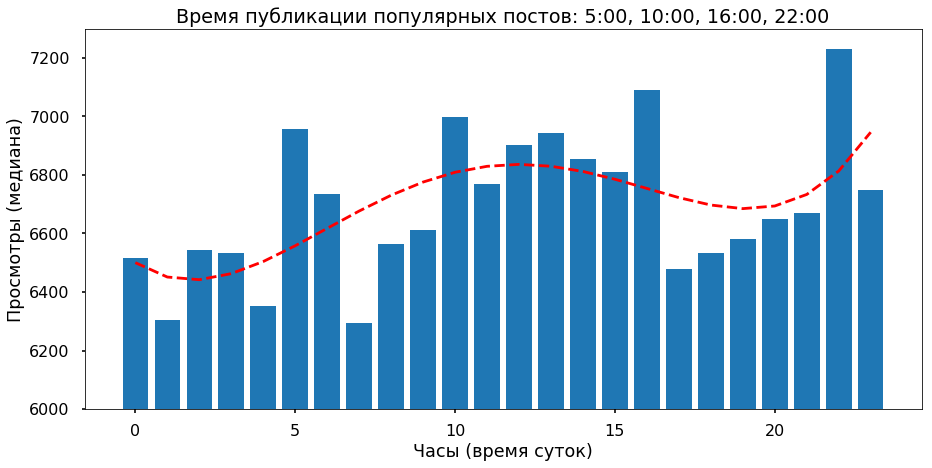

In [15]:
# Данные по времени публикации
df_hours = df[['hours', 'counts']]
df_hours = df_hours.groupby(['hours'])
df_hours = df_hours.counts.median().reset_index()
df_hours.hours = df_hours.hours.astype('int')

# Plot
fig = plt.figure(figsize=(15, 7))
plt.bar(df_hours.hours.tolist(), df_hours.counts.tolist())
z = np.polyfit(df_hours.hours.tolist(), df_hours.counts.tolist(), 4)
p = np.poly1d(z)
plt.plot(df_hours.hours.tolist(), p(df_hours.hours.tolist()),"r--")
plt.ylim(6000, 7300)
plt.title("Время публикации популярных постов: 5:00, 10:00, 16:00, 22:00")
plt.xlabel('Часы (время суток)')
plt.ylabel('Просмотры (медиана)')
plt.show()
fig.savefig('../images/Час публикации.png')

### Время на сайте

In [47]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [20]:
# Время на сайте
df_age = df.groupby(['age'])['counts'].median().reset_index()
df_age = df_age.sort_values(['counts'], ascending=False)
df_age['age'] = ["от 1 до 2 лет", "менее 1 года", "от 2 до 3 лет", "от 5 до 6 лет", 
                 "от 4 до 5 лет", "от 3 до 4 лет", "более 6 лет"]

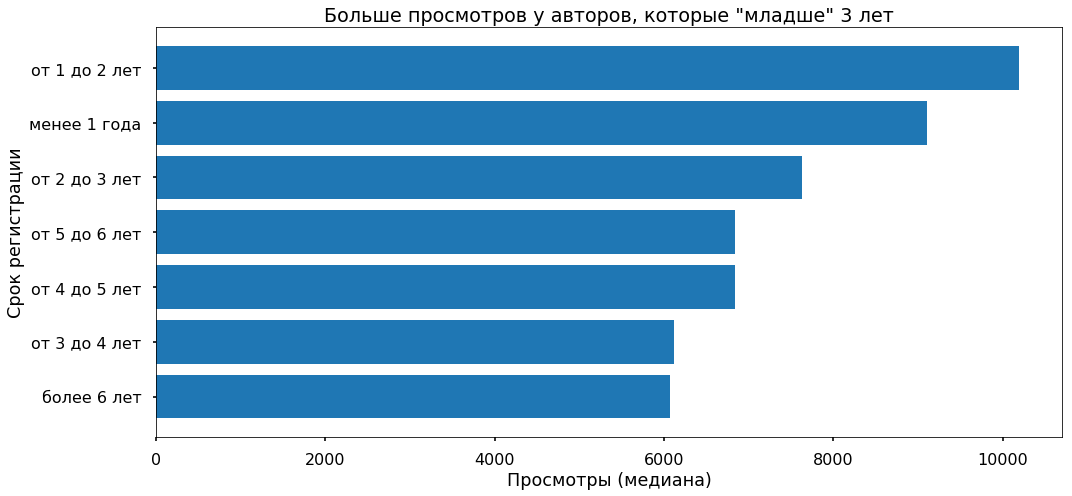

In [27]:
# Plot
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_age.age))[::-1], df_age.counts)
ax.set_yticks(np.arange(len(df_age.age))[::-1])
ax.set_yticklabels(df_age.age)
plt.title('Больше просмотров у авторов, которые "младше" 3 лет')
plt.ylabel('Срок регистрации')
plt.xlabel('Просмотры (медиана)')
plt.tight_layout()
plt.show()
fig.savefig('../images/Время на сайте.png')

In [48]:
# Распределение количества публикаций за 2017-2018 гг. по срокам регистрации. 
# Авторам, которые младше 3 лет, принадлежат 40% публикаций. 
# 60% публикаций за последние три года принадлежат авторам старше 3 лет.
df = df[df.year >= 2016]
df = df[['age']]
df.age = df.age.astype('category')
df.age.value_counts()/df.age.value_counts().sum()*100

2    25.154730
3    20.269673
6    15.340407
1    13.389699
5    12.312113
4    10.770336
0     2.763042
Name: age, dtype: float64

### День недели

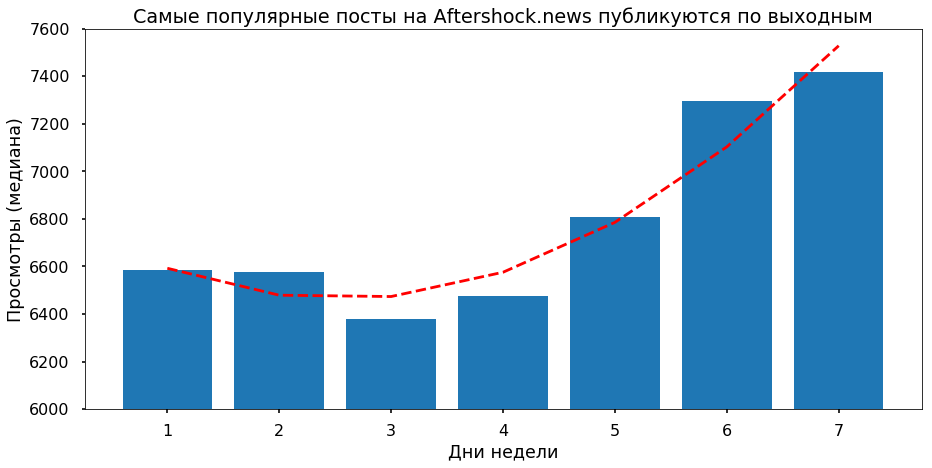

In [74]:
# Сабсет со временем суток
df_week = df[['date', 'counts']]
df_week.date = pd.to_datetime(df_week.date)
df_week['week'] = df_week.date.dt.weekday_name
df_week.index = df_week.pop('date')
df_week = df_week.groupby(['week'])
df_week = df_week.counts.median().reset_index()
df_week.index = df_week.pop('week')
df_week['week'] = [5, 1, 6, 7, 4, 2, 3]
df_week = df_week.sort_values('week')

# Plot
fig = plt.figure(figsize=(15, 7))
plt.bar(df_week.week.tolist(), df_week.counts.tolist())
z = np.polyfit(df_week.week.tolist(), df_week.counts.tolist(), 2)
p = np.poly1d(z)
plt.plot(df_week.week.tolist(), p(df_week.week.tolist()),"r--")
plt.ylim(6000, 7600)
plt.title("Самые популярные посты на Aftershock.news публикуются по выходным")
plt.xlabel('Дни недели')
plt.ylabel('Просмотры (медиана)')
plt.show()
fig.savefig('../images/День публикации.png')

### Авторство
_Данные из предыдущего исследования: 85% авторов из России, второе место -- Нидерланды (3%), третье -- Украина (2%)_

In [81]:
# Данные для постов с указанием авторства
df_auth = df[['authorship', 'counts']]
df_auth = df_auth[df.authorship != 'неизвестно']

In [98]:
# 10,7 тыс. просмотров в среднем для копий
df_auth.counts[df_auth.authorship == "Копия чужих материалов"].mean()

10732.592700343825

In [97]:
# 11,1 тыс. просмотров в среднем для авторских работ
df_auth.counts[df_auth.authorship == "Авторская работа / переводика"].mean()

11118.340210439446

In [129]:
# Авторские материалы составляют 56%
df_auth.authorship[df_auth.authorship == "Авторская работа / переводика"].value_counts() # 4847 авторских материалов
df_auth.authorship[df_auth.authorship == "Копия чужих материалов"].value_counts() # 3781 копий
4847/(4847+3781)*100

56.177561427909126

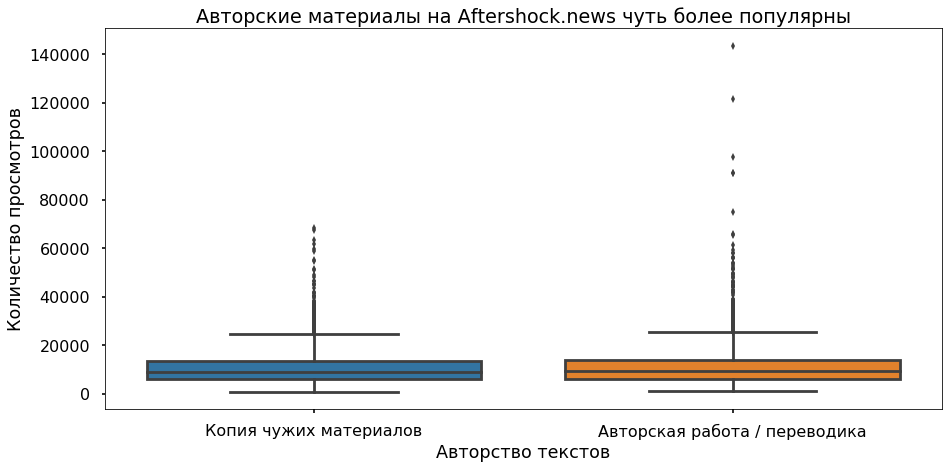

In [101]:
# Plot
fig = plt.figure(figsize=[15, 7])
sns.boxplot(x='authorship', y='counts', data=df_auth)
plt.title('Авторские материалы на Aftershock.news чуть более популярны')
plt.ylabel('Количество просмотров')
plt.xlabel('Авторство текстов')
plt.show()
fig.savefig('../images/Аторство публикаций.png')

### Источник текста

In [16]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')
df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

In [115]:
# Данные для постов, в которых указан источник
df_sources = df[['sources']]
df_sources = pd.DataFrame(df_sources.sources.value_counts()/sum(df_sources.sources.value_counts())*100)
df_sources = df_sources[~df_sources.index.isin(['неизвестно', 'источник', 'Источник', 'статья', 'АфтерШок'])]
df_sources = df_sources.head(10)
df_sources['index1'] = df_sources.index

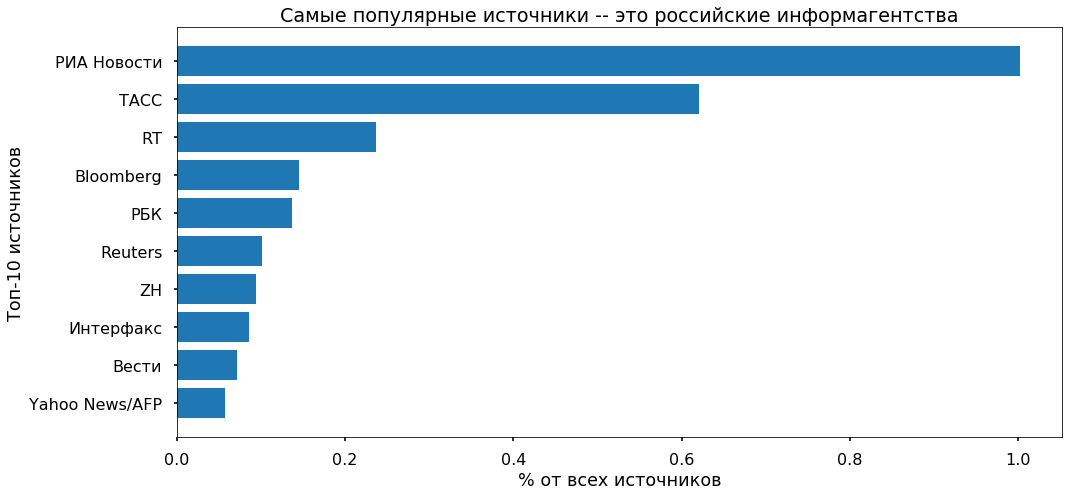

In [136]:
# Plot
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(111)
ax.barh(np.arange(len(df_sources.index1))[::-1], df_sources.sources)
ax.set_yticks(np.arange(len(df_sources.index1))[::-1])
ax.set_yticklabels(df_sources.index1)
plt.title('Самые популярные источники -- это российские информагентства')
plt.ylabel('Топ-10 источников')
plt.xlabel('% от всех источников')
plt.tight_layout()
plt.show()
fig.savefig('../images/Источники текстов.png')

## Анализ текста

### Подготовка текста

In [3]:
# Загрузка данных
df = pd.read_csv('../data/20180215_aftershock.csv')

In [4]:
# Топ 500 самых популярных/непопулярных постов
df = df[df.year >= 2016]
df = df[['counts', 'texts']]
df = df.sort_values('counts', ascending=False)
df['quality'] = 'middle'
df.quality[df.index.isin(df.head(500).index)] = 'top100'
df.quality[df.index.isin(df.tail(500).index)] = 'bottom100'
df = df[df.quality != 'middle']
df = df.reset_index()

In [5]:
# Очистка текста
df.texts = df.texts.str.lower()
df.texts = df.texts.str.replace(r'[^йцукенгшщзхъфывапролджэячсмитьбюё ]', ' ')
df.texts = df.texts.str.replace(r' {2,}', ' ')
df.texts = df.texts.str.replace(r'^ ', '')
df.texts = df.texts.str.replace(r' $', '')

In [6]:
# Нормализация текста
morph = pymorphy2.MorphAnalyzer()
for i in range(0, len(df.texts)):
    string = ''
    for j in df.texts[i].split(' '):
        string += morph.parse(j)[0].normal_form + ' '
    df.texts[i] = string

### Тематическое моделирование

In [7]:
# Анализ Топ 500 текстов
documents = df.texts[df.quality == 'top100'].tolist()
documents = [[word for word in document.split()] for document in documents]

dictionary = corpora.Dictionary(documents)
dictionary.save('../data/deerwester.dict')

corpus = [dictionary.doc2bow(text) for text in documents]
corpora.MmCorpus.serialize('../data/deerwester.mm', corpus) 

dictionary = corpora.Dictionary.load('../data/deerwester.dict')
corpus = corpora.MmCorpus('../data/deerwester.mm')

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [35]:
# Темы для Топ 500
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
lsi.print_topics(2)

[(0,
  '0.130*"я" + 0.125*"мы" + 0.101*"вы" + 0.098*"украина" + 0.095*"россия" + 0.091*"не" + 0.088*"сша" + 0.086*"то" + 0.085*"путин" + 0.081*"они"'),
 (1,
  '0.270*"сирия" + 0.191*"сирийский" + 0.166*"удар" + 0.148*"самолёт" + -0.137*"я" + 0.135*"военный" + 0.126*"риа" + 0.113*"ракета" + 0.113*"коалиция" + 0.111*"сша"')]

In [15]:
# Анализ Bottom 500 текстов
documents1 = df.texts[df.quality != 'top100'].tolist()
documents1 = [[word for word in document.split()] for document in documents1]

dictionary1 = corpora.Dictionary(documents1)
dictionary1.save('../data/deerwester1.dict')

corpus1 = [dictionary1.doc2bow(text) for text in documents1]
corpora.MmCorpus.serialize('../data/deerwester1.mm', corpus1)  # store to disk, for later use

dictionary1 = corpora.Dictionary.load('../data/deerwester1.dict')
corpus1 = corpora.MmCorpus('../data/deerwester1.mm')

tfidf1 = models.TfidfModel(corpus1)
corpus_tfidf1 = tfidf1[corpus1]

In [19]:
# Темы для Bottom 500 текстов
lsi1 = models.LsiModel(corpus_tfidf1, id2word=dictionary1, num_topics=20)
lsi1.print_topics(5)

[(0,
  '0.712*"шт" + 0.395*"буров" + 0.185*"месторождение" + 0.148*"минимум" + 0.146*"б" + 0.131*"прирост" + 0.122*"составлять" + 0.117*"недельный" + 0.114*"бурение" + 0.109*"далее"'),
 (1,
  '0.404*"б" + -0.310*"шт" + 0.298*"далее" + 0.231*"сырой" + 0.226*"тысяча" + -0.172*"буров" + 0.157*"запас" + 0.150*"отметка" + 0.141*"нефть" + 0.125*"составить"'),
 (2,
  '0.344*"б" + 0.243*"далее" + 0.206*"сырой" + -0.160*"том" + -0.145*"перевозка" + 0.129*"отметка" + -0.128*"миллион" + 0.127*"запас" + 0.107*"тысяча" + -0.102*"год"'),
 (3,
  '-0.260*"перевозка" + -0.245*"том" + -0.190*"погрузка" + -0.155*"уголь" + -0.150*"миллион" + -0.131*"груз" + -0.120*"экспорт" + -0.116*"прошлое" + -0.109*"удобрение" + -0.107*"зерно"'),
 (4,
  '-0.395*"иран" + -0.147*"китай" + -0.137*"миллиард" + 0.130*"я" + -0.125*"компания" + -0.121*"баррель" + -0.114*"сирия" + -0.112*"добыча" + -0.110*"нефть" + 0.109*"мой"')]

### Облака тегов для 100 наиболее влиятельных слов

In [73]:
# Конвертация текстов и маркеров в листы
texts = df.texts.tolist()
labels = df.quality.tolist()

# Обучение модели
model = SGDClassifier()
text_vect = TfidfVectorizer().fit(texts)
text_vect_tr = text_vect.transform(texts)
model.fit(text_vect_tr, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [9]:
# Топ 100 наиболее влиятельных слов
feature_names = np.array(text_vect.get_feature_names())
sorted_coef = model.coef_[0].argsort()
# feature_names = feature_names[sorted_coef[:100]]
feature_names = feature_names[sorted_coef[:-101:-1]]

In [41]:
feature_names = ['россия', 'путин', 'удар', 'украина', 'рубль',
       'видео', 'русский', 'российский', 'инджирлик', 'поставка',
       'мировой', 'дом', 'стиральный', 'запад', 'балл', 'газа',
       'тесло', 'система', 'германия', 'сша', 'субсидия', 
       'происшествие', 'самолёт', 'комментарий', 'пресс',
       'выручка', 'иранский', 'алеппо', 'зона', 'компьютер', 'федерация',
       'чёрный', 'трамп', 'средство', 'событие', 'коалиция', 'фото', 
       'ввс', 'администрация',
       'население', 'блокада', 'путч', 'ядерный', 'латвия', 'клинтон',
       'порошенко', 'захарченко', 'увидеть', 'таня', 'гусеничный',
       'условный', 'посол', 'эрдогать', 'тонна', 'стаж', 'польша',
       'ураган', 'немедленный', 'чуркин', 'фрс', 'открытие', 'следующий',
       'мясо', 'независимость', 'безвизовый', 'температура',
       'ракета', 'загрузка', 'обвал', 'договор', 
       'отель', 'прохоров', 'куб', 'сотня', 'танк', 'скорость',
       'мониторинг', 'свая', 'биометрический', 'зима', 'оружие',
       'оперативный', 'полный']

In [21]:
# Создание цветовой карты
colors = ["#000000", "#111111", "#222222"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

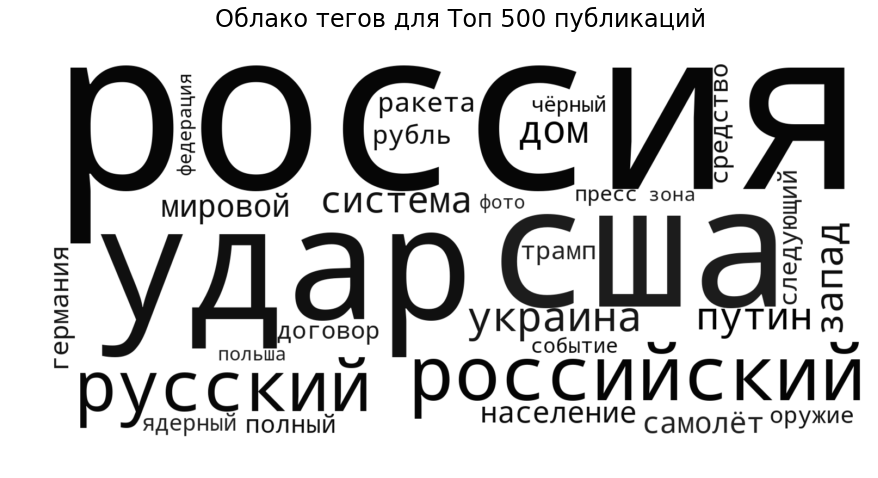

In [43]:
# Облако тегов для Топ 500 публикаций
words = ' '.join(df.texts[df.quality == 'top100']).split(' ')
string = {}
for i in feature_names:
    string[i] = len(re.findall(i, str(words)))/len(words)
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=500,
                            width=1500,
                            height=700,
                            max_words=30,
                            relative_scaling=0.5,
                            stopwords = []
                            ).generate_from_frequencies(string)
fig = plt.figure(figsize=(15,7))
plt.title('Облако тегов для Топ 500 публикаций\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()

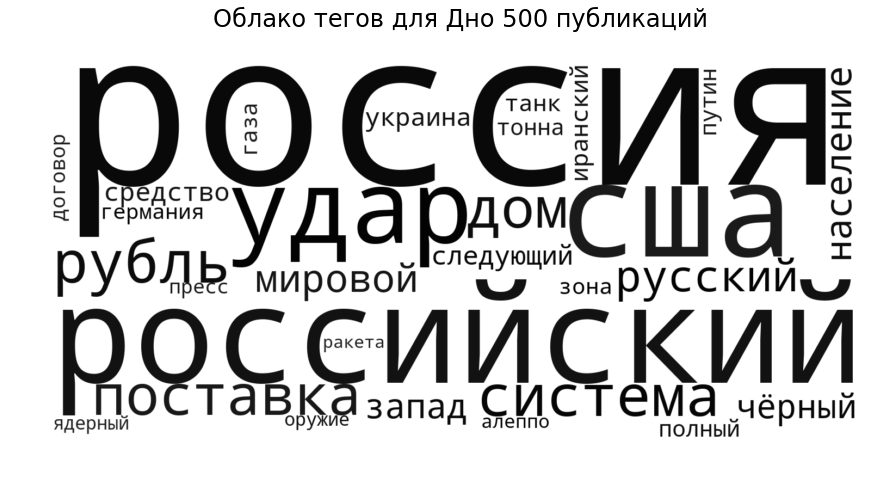

In [45]:
# Облако тегов для 100 самых непопулярных публикаций
words1 = ' '.join(df.texts[df.quality != 'top100']).split(' ')
string1 = {}
for i in feature_names:
    string1[i] = len(re.findall(i, str(words1)))/len(words1)
cloud = wordcloud.WordCloud(background_color='white',
                            colormap=cmap,
                            max_font_size=400,
                            width=1500,
                            height=700,
                            max_words=30,
                            relative_scaling=.5,
                            stopwords = []
                            ).generate_from_frequencies(string1)
fig = plt.figure(figsize=(15,7))
plt.title('Облако тегов для Дно 500 публикаций\n', fontsize=24)
plt.axis('off')
plt.imshow(cloud, interpolation="bilinear")
plt.show()

### Тестирование различных моделей для предсказания популярности текста

In [42]:
# Создание функции конвейерной подачи данных
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [43]:
# Тестирование моделей
for clf in [LogisticRegression, LinearSVC, SGDClassifier]:
    print (clf)
    print (cross_val_score(text_classifier(CountVectorizer(), TfidfTransformer(), clf()), texts, labels).mean())
    print ("\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.815050621648


<class 'sklearn.svm.classes.LinearSVC'>
0.849036866027


<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0.835010701489




In [44]:
# Обучение выбранной модели
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LogisticRegression())]
        )
clf_pipeline.fit(texts, labels)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tr...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [46]:
# Тестирование модели на случайном примере
test = 'Наткнулся на любопытный справочный материал по финансированию международных организаций (МО) и доли участия отдельных стран в формировании их бюджетов. Доклад подготовлен экспертами Брукингского института (опубликован в декабре), даётся информация по около 30 организациям связанным с ООН и другим, таким как Глобальный альянс по вакцинам и иммунизации, Совет Европы, Международная ассоциация развития (Всемирный банк) и Фонд чистых технологий (зелёные бесы).'
print('Пост "выстрелит" с вероятностью {}%'.format(int(round(clf_pipeline.predict_proba([test])[0][1]*100, 0))))

Пост "выстрелит" с вероятностью 35%


In [47]:
# Тестирование модели на тексте с сайта
page = requests.get('https://aftershock.news/?q=node/607738')
page.encoding = 'utf-8'
post = BeautifulSoup(page.text, "lxml")
post = str(post.find_all('article', class_='aft-post aft-article'))
print('Пост "выстрелит" с вероятностью {}%'.format(int(round(clf_pipeline.predict_proba([post])[0][1]*100, 0))))

Пост "выстрелит" с вероятностью 82%


In [48]:
# Сохранение модели
pickle.dump(clf_pipeline, open('clf_pipeline.sav', 'wb'))